In [1]:
"""
re-do of cross dataset analysis between ABA ISH and cantin ST
includes plot of ranked mean expression across the two datasets

Shaina Lu
Zador & Gillis Labs
May 2020
"""

'\nre-do of cross dataset analysis between ABA ISH and cantin ST\ninclude plot of ranked mean expression across the two datasets\n\nShaina Lu\nZador & Gillis Labs\nMay 2020\n'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #stratify train/test split
import random

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

### Read in files and pre-processing

In [4]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"
#NCBI_CONV_PATH = "/data/slu/refs/ncbi_mouse_gene_info_190913"

In [5]:
#ABA
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology

Functions copied from allenadultmouseISH/allbyall_cross.py \
filterproponto is modified to match ST and ABA allbyall

In [6]:
def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    """helper function to get only leaf brain areas"""
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    print("number of leaf areas: %d" %len(leaves))
    return leaves

def findoverlapareas(STonto, propontvox, ontology):
    """find leaf brain areas overlapping between the two datasets"""
    leafST = getleaves(STonto, ontology)
    leafABA = getleaves(propontvox, ontology)

    leafboth = [] 
    for i in range(len(leafABA)):
        if leafABA[i] in leafST:
            leafboth.append(leafABA[i])
    
    STonto = STonto.loc[:,leafboth]
    propontvox = propontvox.loc[:,leafboth]
    
    return STonto, propontvox    

def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score on whole data set before splitting into test and train
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label (ctxnotctx)
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels)
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

### find overlapping genes

Prior, I converted genes to entrez IDs first and then looked at overlapping genes in the entrez id space (14182 overlapping genes). However, this is on hold, because I tried to look at gene symbols only and I actually get 14299 overlapping genes. \
\
I have to point out however that there are more likely to be more overlapping genes since there are more genes kept in the Cantin ST as a larger dataset (verify). 

In [7]:
#ncbi = pd.read_csv(NCBI_CONV_PATH, sep='\t')

In [7]:
def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox

### LASSO functions

In [8]:
def applyLASSO(Xtrain, Xtest, Xcross, ytrain, ytest, ycross):
    """apply LASSO regression"""
    #lasso_reg = sklearn.linear_model.Lasso(alpha=alphaval)
    lasso_reg = Lasso(alpha=0.1,max_iter=10000) #alpha=alphaval) #,max_iter=10000)
    #lasso_reg = LinearRegression()
    lasso_reg.fit(Xtrain, ytrain)
    
    #train
    predictions_train = lasso_reg.predict(Xtrain)
    auroc_train = analytical_auroc(sp.stats.mstats.rankdata(predictions_train), ytrain)
    #auroc_train = metrics.roc_auc_score(y_true = ytrain, y_score = predictions_train)
    #test
    predictions_test = lasso_reg.predict(Xtest)
    auroc_test = analytical_auroc(sp.stats.mstats.rankdata(predictions_test), ytest)
    #auroc_test = metrics.roc_auc_score(y_true = ytest, y_score = predictions_test)
    
    #cross
    predictions_cross = lasso_reg.predict(Xcross)
    auroc_cross = analytical_auroc(sp.stats.mstats.rankdata(predictions_cross), ycross)
    
    return auroc_train, auroc_test, auroc_cross

In [14]:
def getallbyall(mod_data, mod_propont, cross_data, cross_propont):
    #initialize zeros dataframe to store entries
    allbyall_test = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))
    allbyall_train = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))
    allbyall_cross = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))

    areas = list(mod_propont)
    #for each column, brain area
    for i in range(mod_propont.shape[1]):
    #for i in range(5,6,1):
        print("col %d" %i)
        #for each row in each column
        for j in range(i+1,mod_propont.shape[1]): #upper triangular!
            area1 = areas[i]
            area2 = areas[j]
            #get binary label vectors
            ylabels = mod_propont.loc[mod_propont[area1]+mod_propont[area2] != 0, area1]
            ycross = cross_propont.loc[cross_propont[area1]+cross_propont[area2] != 0, area1]
            #ylabels = pd.Series(np.random.permutation(ylabels1),index=ylabels1.index) #try permuting
            #subset train and test sets for only samples in the two areas
            Xcurr = mod_data.loc[mod_propont[area1]+mod_propont[area2] != 0, :]
            Xcrosscurr = cross_data.loc[cross_propont[area1]+cross_propont[area2] != 0, :]
            #split train test for X data and y labels
            #split data function is seeded so all will split the same way
            Xtrain, Xtest, ytrain, ytest = train_test_split(Xcurr, ylabels, test_size=0.5,\
                                                            random_state=42, shuffle=True,\
                                                            stratify=ylabels)
            #z-score train and test folds
            zXtrain = zscore(Xtrain)
            zXtest = zscore(Xtest)
            zXcross = zscore(Xcrosscurr)

            currauroc_train, currauroc_test, currauroc_cross = applyLASSO(zXtrain, zXtest, zXcross, ytrain, ytest, ycross)
            allbyall_train.iloc[i,j] = currauroc_train
            allbyall_test.iloc[i,j] = currauroc_test
            allbyall_cross.iloc[i,j] = currauroc_cross

        #if i == 1:
        break

    return allbyall_train, allbyall_test, allbyall_cross

### main

In [8]:
#read in data
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()
STmeta, STspots, STpropont = read_STdata()

In [9]:
#filter brain areas for those that have at least x samples
STpropont = filterproponto(STpropont)
ABApropont = filterproponto(ABApropont)
#filter brain areas for overlapping leaf areas
STpropont, ABApropont = findoverlapareas(STpropont, ABApropont, ontology)

number of leaf areas: 461
number of leaf areas: 560


In [10]:
#keep only genes that are overlapping between the two datasets
STspots, ABAvox = getoverlapgenes(STspots, ABAvox)

number of overlapping genes: 14299


In [15]:
#predictability matrix using LASSO
allbyall_train, allbyall_test, allbyall_cross = getallbyall(STspots, STpropont, ABAvox, ABApropont)

col 0


In [ ]:
#allbyall_test.to_csv(ST_TEST_OUT, sep=',', header=True, index=False)
#allbyall_train.to_csv(ST_TRAIN_OUT, sep=',', header=True, index=False)
#allbyall_cross.to_csv(ABA_ALL_OUT, sep=',', header=True, index=False)

# ranked mean expression across samples between ABA and ST
### use dataset filtering for cross dataset, mean expression across all samples

In [12]:
#get mean expression for each gene
STmeans = STspots.mean(axis=0)
ABAmeans = ABAvox.mean(axis=0)

In [13]:
#rank
STmeans = sp.stats.mstats.rankdata(STmeans)
ABAmeans = sp.stats.mstats.rankdata(ABAmeans)

In [18]:
print(sp.stats.pearsonr(STmeans, ABAmeans))
print(sp.stats.spearmanr(STmeans, ABAmeans))

(0.5993543916464903, 0.0)
SpearmanrResult(correlation=0.5993543916464903, pvalue=0.0)


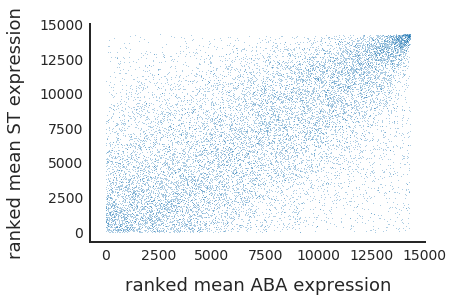

In [26]:
plt.scatter(ABAmeans, STmeans,s=0.1)
plt.xlabel("ranked mean ABA expression")
plt.ylabel("ranked mean ST expression")
plt.savefig("062620_3.pdf", bbox_inches='tight')
plt.show()

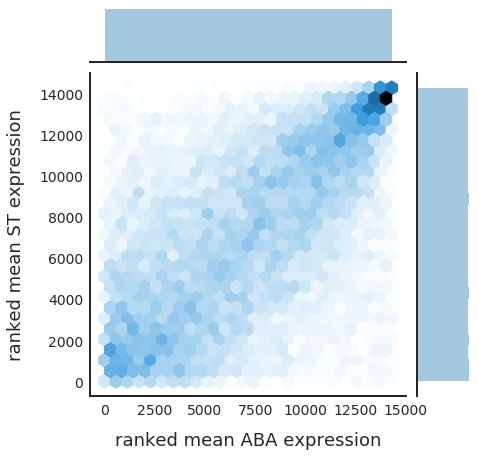

In [32]:
sns.jointplot(ABAmeans, STmeans, kind='hex').set_axis_labels("ranked mean ABA expression","ranked mean ST expression")
plt.savefig("062620_4.pdf", bbox_inches='tight')
plt.show()

### same, but for specific brain areas (hippocampus)

In [14]:
ontology.loc[ontology.acronym == "HPF",:]

,id,acronym,name,parent,allencolor
329,1089,HPF,Hippocampal formation,695.0,#7ED04B


In [27]:
ontology.loc[ontology.parent == 1089,:]

,id,acronym,name,parent,allencolor
301,1080,HIP,Hippocampal region,1089.0,#7ED04B
588,822,RHP,Retrohippocampal region,1089.0,#32B825


In [30]:
#i did not finish writing this, just bailed and harcoded children areas
hpfleafs = []
haschildren = True
seed = 1089
while haschildren:
    nextseeds = ontology.loc[ontology.parent == seed, "id"]
    break
print(nextseeds)

301    1080
588     822
Name: id, dtype: int64


In [34]:
#not including retrohippocampal region
hpfleafacros = ['FC','IG',\
                'CA1slm','CA1so','CA1sp','CA1sr',\
                'CA2slm','CA2so','CA2sp','CA2sr',\
                'CA3slm','CA3slu','CA3so','CA3sp','CA3sr',\
                'DG-mo','DG-po','DG-sg','DG-sgz',\
                'DGcr-mo','DGcr-po','DGcr-sg',\
                'DGlb-mo','DGlb-po','DGlb-sg',\
                'DGmb-mo','DGmb-po','DGmb-sg']

In [65]:
#get ids for acronyms
hpfleafids = ontology.loc[ontology.acronym.isin(hpfleafacros),'id'].astype(str).tolist()

In [66]:
#filter ids for only areas in the filtered ST and ABA datasets
#pd.Series(hpfleafids).isin(list(STpropont)) == pd.Series(hpfleafids).isin(list(ABApropont)) #True
hpfleafids = pd.Series(hpfleafids)
hpfleafids = hpfleafids[hpfleafids.isin(list(STpropont))]

In [74]:
#index datasets for only those in the leaf brain areas of interest and average over all samples
SThpfmean = STspots.loc[STpropont[hpfleafids].sum(axis=1) >= 1.0,:].mean(axis=0)
ABAhpfmean = ABAvox.loc[ABApropont[hpfleafids].sum(axis=1) >= 1.0,:].mean(axis=0)

In [76]:
#rank
SThpfmeans = sp.stats.mstats.rankdata(SThpfmean)
ABAhpfmeans = sp.stats.mstats.rankdata(ABAhpfmean)

In [77]:
print(sp.stats.pearsonr(SThpfmeans, ABAhpfmeans))
print(sp.stats.spearmanr(SThpfmeans, ABAhpfmeans))

(0.6292679537073924, 0.0)
SpearmanrResult(correlation=0.6292679537073924, pvalue=0.0)


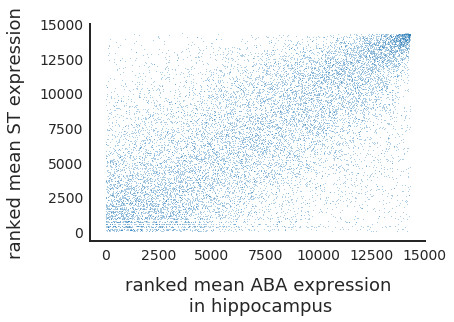

In [80]:
plt.scatter(ABAhpfmeans, SThpfmeans,s=0.1)
plt.xlabel("ranked mean ABA expression\n in hippocampus")
plt.ylabel("ranked mean ST expression")
plt.savefig("091820_1.pdf", bbox_inches='tight')
plt.show()

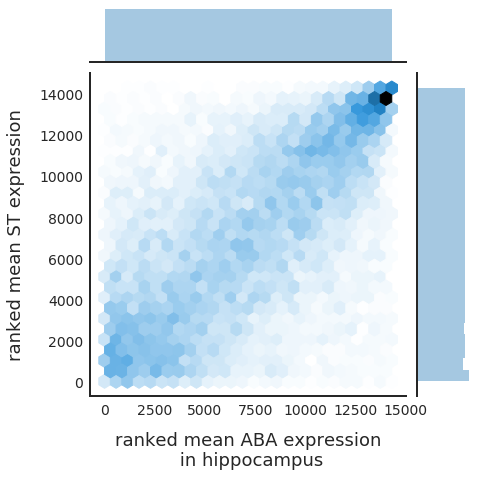

In [81]:
sns.jointplot(ABAhpfmeans, SThpfmeans, kind='hex').set_axis_labels("ranked mean ABA expression\n in hippocampus","ranked mean ST expression")
plt.savefig("091820_2.pdf", bbox_inches='tight')
plt.show()

### look at leaf brain areas individually

In [83]:
hpfleafids

0       632
1       504
5       431
6       486
7       407
8     10703
9       471
10      391
11    10704
13      399
14      454
16      438
17      415
19      479
22      495
24      982
25      446
dtype: object

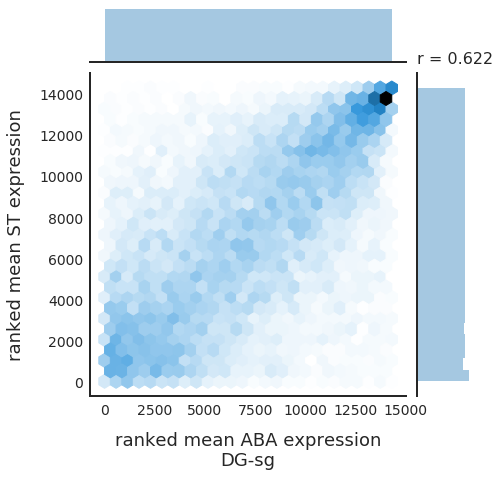

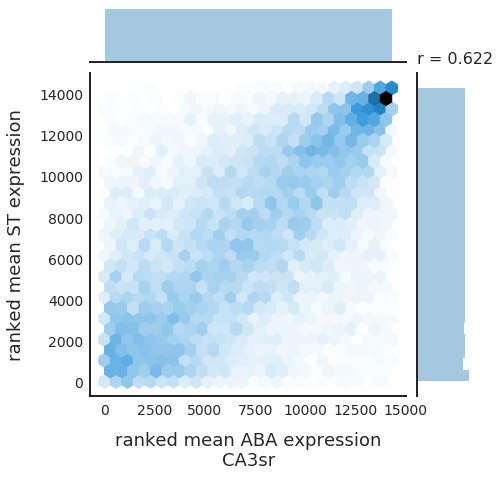

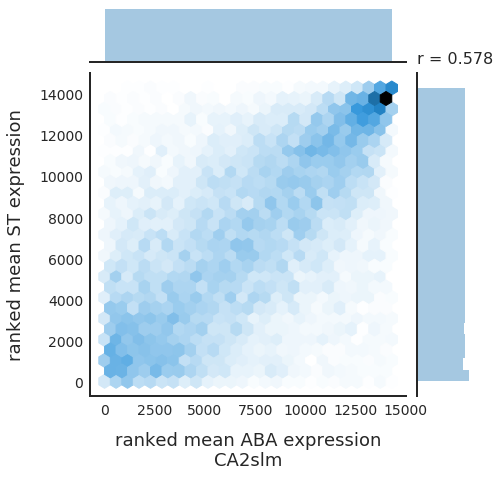

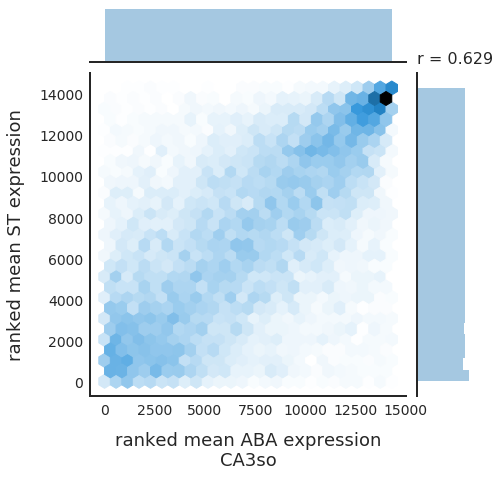

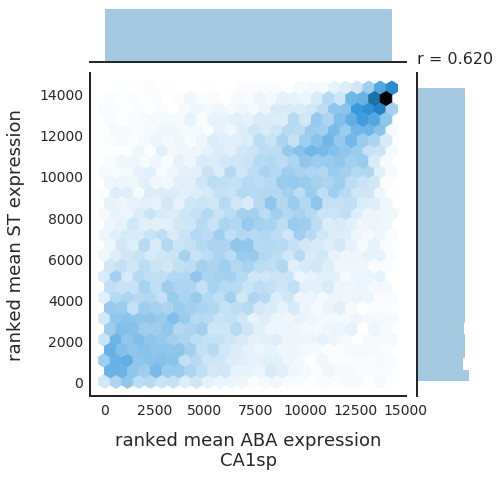

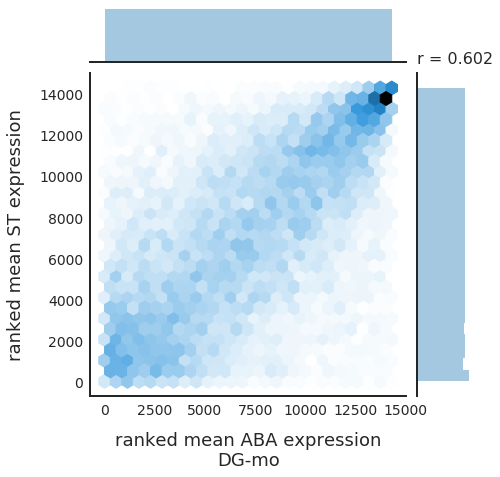

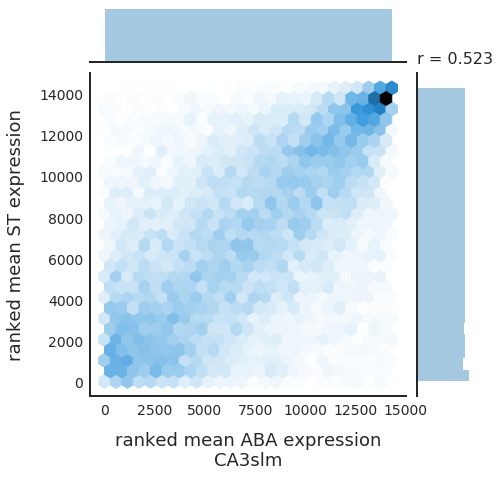

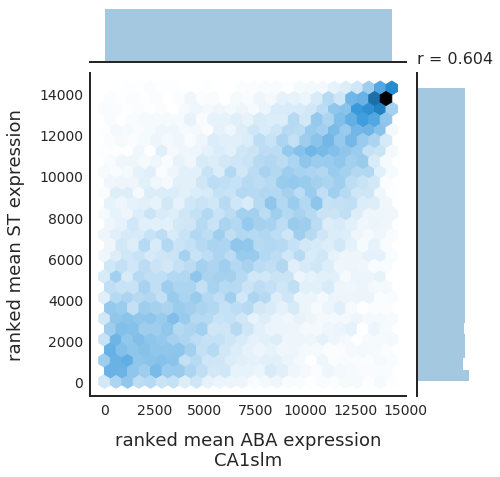

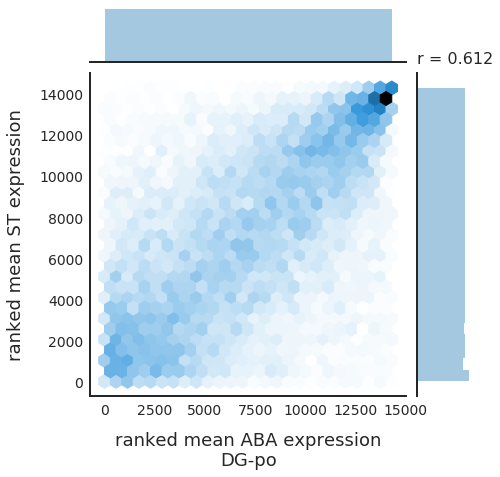

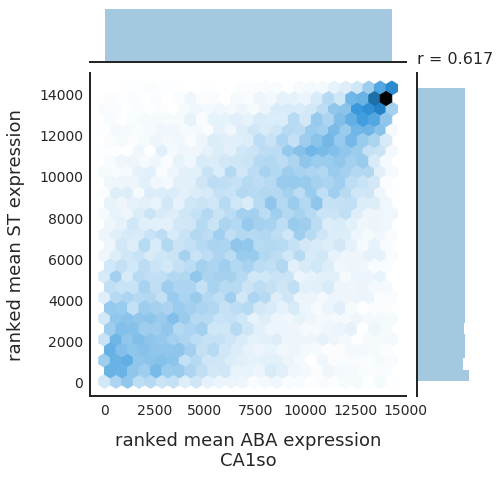

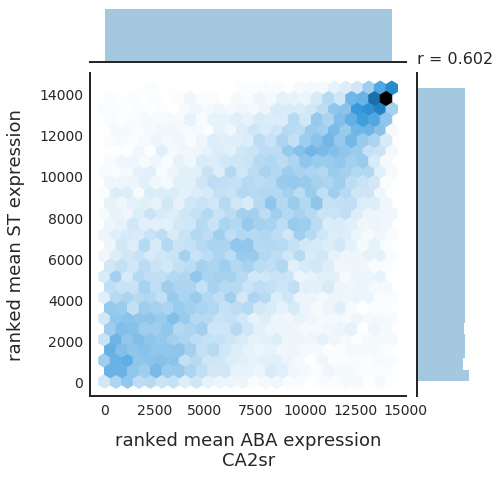

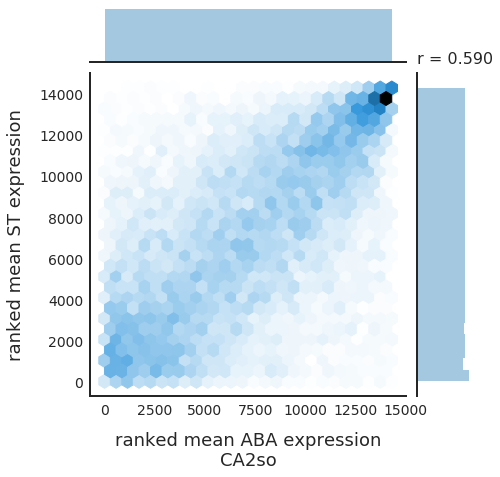

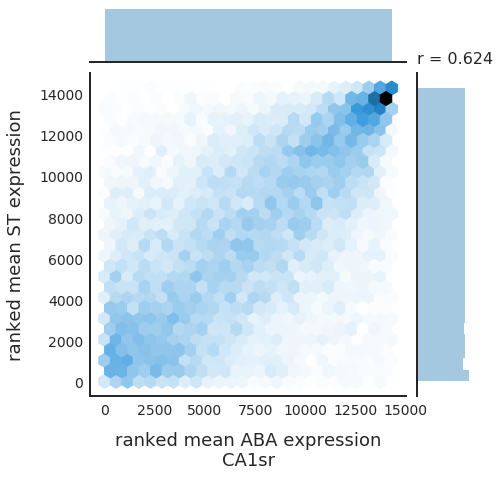

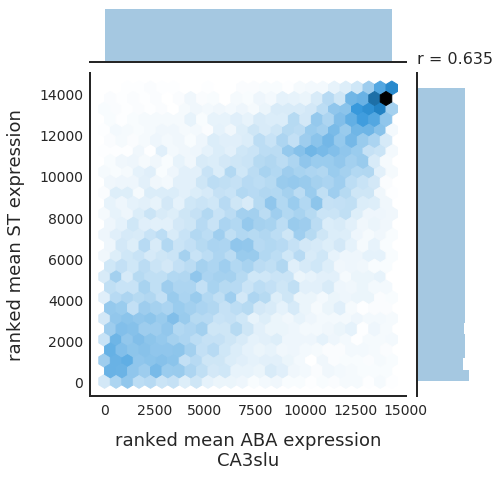

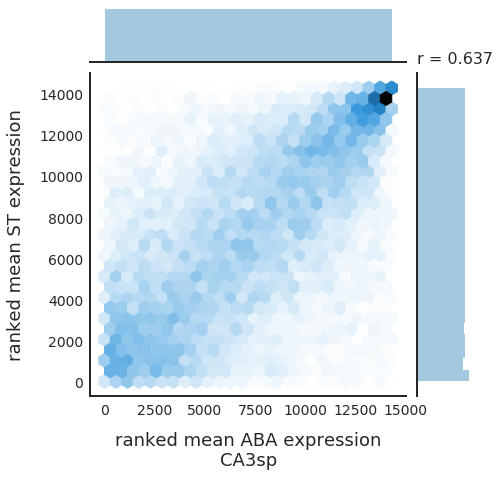

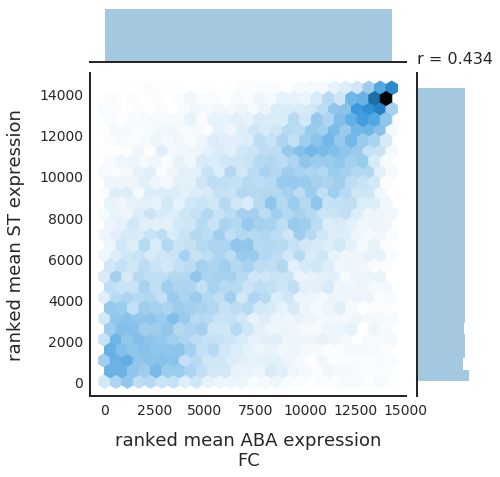

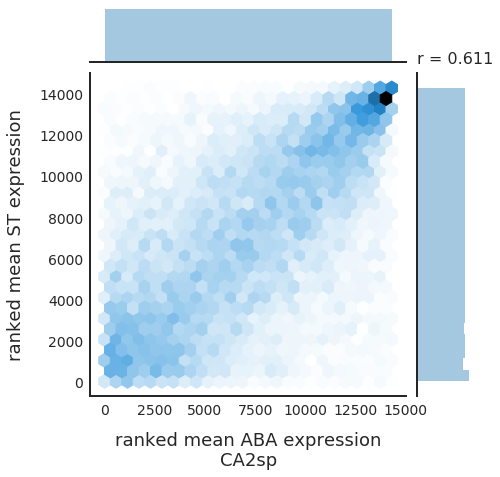

In [118]:
i=1
for hpfid in hpfleafids:
    #index datasets for only those in the leaf brain areas of interest and average over all samples
    currSTmean = STspots.loc[STpropont[hpfid] == 1.0,:].mean(axis=0)
    currABAmean = ABAvox.loc[ABApropont[hpfid] == 1.0,:].mean(axis=0)
    
    #rank
    currSTrankedmean = sp.stats.mstats.rankdata(currSTmean)
    currABArankedmean = sp.stats.mstats.rankdata(currABAmean)
    
    #correlation coefficients
    currcorr = sp.stats.pearsonr(currSTrankedmean, currABArankedmean)[0]
    #print(sp.stats.spearmanr(currSTrankedmean, currABArankedmean)) #same cause already ranked
    
    #plot
    sns.jointplot(ABAhpfmeans, SThpfmeans, kind='hex').set_axis_labels("ranked mean ABA expression\n%s" %(ontology.loc[ontology.id == int(hpfid),'acronym'].iloc[0]),"ranked mean ST expression")
    plt.text(0,15500,"r = %.3f" %currcorr, size=16)
    plt.savefig("092120_%d.pdf" %i, bbox_inches='tight')
    i+=1 #figure naming iter
    plt.show()         